In [14]:
from glob import glob
from itertools import cycle
import os
import pickle
from pprint import pprint

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import colorConverter as cc
import numpy as np
from scipy.interpolate import interp1d

RESULTS_DIRS = {
    '50 epohcs': '/tmp/dynamic_scm_discovery',
    '5 epohcs': '/tmp/dynamic_scm_discovery_backup'
}

TAG = 'foobar'

def get_colors():
#     return cycle(('orange', 'blue', 'green', 'cyan'))
    return ('orange', 'blue', 'green', 'cyan')


In [15]:
# load metrics from disk

all_metric_filenames = {}
all_metrics_per_run = {}

for label, results_dir in RESULTS_DIRS.items():
    metric_filenames = glob('%s/metrics*.p' % results_dir )
    metric_filenames = sorted(metric_filenames)
    metrics_per_run = dict()
    for filename in metric_filenames:
        metrics_per_run[filename] = pickle.load(open(filename, "rb" ))
    
    all_metric_filenames[label] = metric_filenames
    all_metrics_per_run[label] = metrics_per_run


In [16]:
# plot utils

def plot_mean_and_CI(mean, lb, ub, x=None, color_mean=None, color_shading=None):
  # plot the shaded range of the confidence intervals
  if x is None:
    x = range(mean.shape[0])
  plt.fill_between(x, ub, lb,
                   color=color_shading, alpha=.5)
  # plot the mean on top
  plt.plot(x, mean, color_mean)


class LegendObject(object):
  def __init__(self, facecolor='red', edgecolor='white', dashed=False):
    self.facecolor = facecolor
    self.edgecolor = edgecolor
    self.dashed = dashed

  def legend_artist(self, legend, orig_handle, fontsize, handlebox):
    x0, y0 = handlebox.xdescent, handlebox.ydescent
    width, height = handlebox.width, handlebox.height
    patch = mpatches.Rectangle(
      # create a rectangle that is filled with color
      [x0, y0], width, height, facecolor=self.facecolor,
      # and whose edges are the faded color
      edgecolor=self.edgecolor, lw=3)
    handlebox.add_artist(patch)

    # if we're creating the legend for a dashed line,
    # manually add the dash in to our rectangle
    if self.dashed:
      patch1 = mpatches.Rectangle(
        [x0 + 2 * width / 5, y0], width / 5, height, facecolor=self.edgecolor,
        transform=handlebox.get_transform())
      handlebox.add_artist(patch1)

    return patch

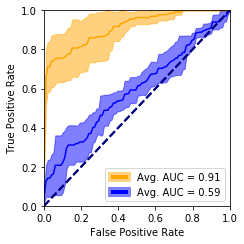

In [20]:
# plot ROC with error bars

all_avg_aucs = []

colors = get_colors()
colors = iter(colors)

for label, metrics_per_run in all_metrics_per_run.items():

    all_avg_aucs.append(np.mean([
        metrics['auc'] for metrics in metrics_per_run.values()
    ]))  # use for legend

    fpr_grid = np.linspace(0., 1., 100)
    interp_tpr = []
    
    metric_filenames = all_metric_filenames[label]
    for i, filename in enumerate(metric_filenames):
        metrics = metrics_per_run[filename]
        fpr = metrics['fpr']
        tpr = metrics['tpr']
        tpr_per_fpr = interp1d(fpr, tpr)
        interp_tpr.append(tpr_per_fpr(fpr_grid))

    # format as np and derive upper and lower error bars
    interp_tpr = np.array(interp_tpr).T
    mean_tpr = interp_tpr.mean(1)
    ub_tpr = mean_tpr + interp_tpr.std(1)
    lb_tpr = mean_tpr - interp_tpr.std(1)

    fig = plt.figure(1, figsize=(3.5, 3.5))
    
    color = next(colors)
    plot_mean_and_CI(mean_tpr, ub_tpr, lb_tpr, fpr_grid, 
                     color_mean=color, color_shading=color)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')


bg = np.array([1, 1, 1])  # background of the legend is white
# with alpha = .5, the faded color is the average of the background and color
colors = get_colors()  # reset colors counter
colors = colors[:len(all_metrics_per_run)]
colors_faded = [(np.array(cc.to_rgb(color)) + bg) / 2.0 for color in colors]
handler_map = {i: LegendObject(colors[i], colors_faded[i]) for i in range(len(colors))}
labels = ['Avg. AUC = {:.2f}'.format(avg_auc) for avg_auc in all_avg_aucs]
plt.legend(list(range(len(colors))), labels, handler_map=handler_map)

plt.tight_layout()
plt.savefig(os.path.join('./roc_with_uncertainty.%s.pdf' % TAG))